In [1]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import models as m

from sktime.datasets import load_from_tsfile_to_dataframe

In [2]:
PREPROCESS = False

In [3]:
CURR_DIR = Path.cwd()
CURR_DIR_PARENT = list(CURR_DIR.parents)
SRC_DIR = CURR_DIR_PARENT[0]

DATA_DIR = SRC_DIR / "data"
DATASET_DIR = DATA_DIR / "RefrigerationDevices"
train_path = DATASET_DIR / "RefrigerationDevices_TRAIN.ts"
test_path  = DATASET_DIR / "RefrigerationDevices_TEST.ts"

RUNS_DIR = CURR_DIR /"runs"

EXP_NAME = "RD_TM_PP_MP"

EXP_ROOT = RUNS_DIR / EXP_NAME
EXP_ROOT.mkdir(parents=True, exist_ok=True)

# On cherche les sous-dossiers numériques existants pour incrémenter l'ID
existing_ids = []
for p in EXP_ROOT.iterdir():
    if p.is_dir() and p.name.isdigit():
        existing_ids.append(int(p.name))

if len(existing_ids) == 0:
    next_id = 0
else:
    next_id = max(existing_ids) + 1

EXP_ID = str(next_id)
EXP_DIR = EXP_ROOT / EXP_ID
EXP_DIR.mkdir(parents=True, exist_ok=False)

print(f"Created new run: {EXP_NAME}/{EXP_ID}")
print("EXP_DIR:", EXP_DIR)

Created new run: RD_TM_PP_MP/5
EXP_DIR: /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/first_Imple/runs/RD_TM_PP_MP/5


## Load data - no preprocess 

In [4]:
# %% [markdown]
# ## Load data (raw vs preprocessed)

# %%

if not PREPROCESS:
    print("using not preprocessed data")

    X_train_df, y_train_arr = load_from_tsfile_to_dataframe(str(train_path))
    X_test_df,  y_test_arr  = load_from_tsfile_to_dataframe(str(test_path))

    print("X_train_df shape:", X_train_df.shape)
    print("X_test_df  shape:", X_test_df.shape)
    print("Example series shape:", X_train_df.iloc[0, 0].shape)

    def df_to_numpy(X_df):
        arr = np.stack([X_df.iloc[i, 0] for i in range(len(X_df))], axis=0)
        return arr[..., np.newaxis]  # (N, T, 1)

    X_train_np = df_to_numpy(X_train_df)
    X_test_np  = df_to_numpy(X_test_df)

    # y -> np.ndarray d'entiers
    y_train_np = np.asarray(y_train_arr, dtype=np.int64)
    y_test_np  = np.asarray(y_test_arr,  dtype=np.int64)

else:
    print("using preprocessed data")

    PREP_DIR = DATASET_DIR / "preprocessed"
    train_npz_path = PREP_DIR / "RefrigerationDevices_TRAIN_preprocessed.npz"
    test_npz_path  = PREP_DIR / "RefrigerationDevices_TEST_preprocessed.npz"

    train_data = np.load(train_npz_path)
    test_data  = np.load(test_npz_path)

    X_train_np = train_data["X"]          # (N_train_clean, T, 1)
    y_train_np = train_data["y"].astype(np.int64)

    X_test_np  = test_data["X"]           # (N_test, T, 1)
    y_test_np  = test_data["y"].astype(np.int64)

print("X_train_np shape:", X_train_np.shape)
print("X_test_np  shape:", X_test_np.shape)
print("Example series shape:", X_train_np[0].shape)


using not preprocessed data
X_train_df shape: (375, 1)
X_test_df  shape: (375, 1)
Example series shape: (720,)
X_train_np shape: (375, 720, 1)
X_test_np  shape: (375, 720, 1)
Example series shape: (720, 1)


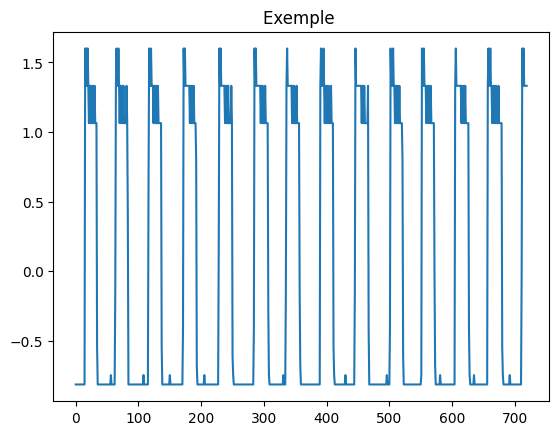

In [ ]:
plt.figure()
plt.plot(X_train_np[2])
plt.title("Exemple ")
plt.show()

## Torch tensors + DataLoaders

In [6]:
X_train_torch = torch.from_numpy(X_train_np).float()
X_test_torch  = torch.from_numpy(X_test_np).float()
y_train_torch = torch.from_numpy(y_train_np.astype(np.int64))
y_test_torch  = torch.from_numpy(y_test_np.astype(np.int64))

# Dataset
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset  = TensorDataset(X_test_torch,  y_test_torch)

BATCH_SIZE = 16  

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,     
    drop_last=False,
)

uuu = iter(train_loader)
x, y = next(uuu)
print( x.shape, y.shape)

torch.Size([16, 720, 1]) torch.Size([16])


## Losses (Instance / Time / Hierarchical)

In [7]:
def InstanceLoss(r1, r2): 
    
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if B == 1:
        return r1.new_tensor(0.)

    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1) 

    B, T, C = z1.size()
    z = torch.cat([z1, z2], dim=0)   # 2B x T x C
    z = z.transpose(0, 1)    # Tx2B xC
    sim = torch.matmul(z, z.transpose(1, 2))  # T x 2B x 2B

    logits = torch.tril(sim, diagonal=-1)[:,:,:-1]    # T x 2B x (2B-1)
    logits += torch.triu(sim, diagonal=1)[:,:,1:]
    logits = -F.log_softmax(logits, dim=-1)

    i = torch.arange(B, device=z1.device)
    loss = (logits[:, i, B + i - 1].mean() + logits[:, B + i, i].mean()) / 2

    return loss


def TimeLoss(r1, r2):
    
    assert r1.shape == r2.shape
    B, K, T = r1.shape

    if T == 1:
        # pas de contraste temporel possible
        return r1.new_tensor(0.)

    # on passe en (B, T, C) = (B, T, K)
    z1 = r1.permute(0, 2, 1)  # (B, T, K)
    z2 = r2.permute(0, 2, 1)  #(B, T, K)


    z = torch.cat([z1, z2], dim=1)   # B x 2T x C
    sim = torch.matmul(z, z.transpose(1, 2))  # B x 2T x 2T

    logits = torch.tril(sim, diagonal=-1)[:, :, :-1]    # B x 2T x (2T-1)
    logits += torch.triu(sim, diagonal=1)[:, :, 1:]
    logits = -F.log_softmax(logits, dim=-1)

    t = torch.arange(T, device=z1.device)
    loss = (logits[:, t, T + t - 1].mean() + logits[:, T + t, t].mean()) / 2

    return loss


def HierLoss(r1, r2, alpha: float = 1/2):
    assert r1.shape == r2.shape
    loss = r1.new_tensor(0.)
    d = 0
    
    # maxpooling jusqu'à n'avoir plus qu'une dimension.
    while r1.size(2) > 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        if d >= 0 and (1 -alpha) != 0:
            loss += (1-alpha)*TimeLoss(r1, r2)
        d += 1

        # pooling hiérarchique le long de T (dim=2) comme 
        r1 = F.max_pool1d(r1, kernel_size=2)  # (B, K, T//2)
        r2 = F.max_pool1d(r2, kernel_size=2)

    # niveau final T == 1:seulement instance loss \
    if r1.size(2) == 1:
        if alpha != 0:
            loss += alpha * InstanceLoss(r1, r2)
        d += 1

    return loss / d

## sauvegarde config

In [ ]:
import torch.optim as optim

if torch.cuda.is_available() : 
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps'
else : 
    device = 'cpu'
    
print("Device:", device)

REP_DIM   = 320
NUM_BLOCKS   = 10
KERNEL_SIZE = 3
LR = 1e-4
N_EPOCH = 30
ALPHA_HIER = 0.5
MASK_PROB = 0.2

model = m.Encoder(
    in_channel=1,
    representation_dim=REP_DIM,
    num_blocks=NUM_BLOCKS,
    kernel_size=KERNEL_SIZE,
    mask_prob = MASK_PROB, # timestamp masking
)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

# log des hyperparams pour pouvoir recharger
config = {
    "dataset": "FRIDGE",
    "in_channel": 1,
    "representation_dim": REP_DIM,
    "num_blocks": NUM_BLOCKS,
    "kernel_size": KERNEL_SIZE,
    "lr": LR,
    "batch_size": BATCH_SIZE,
    "n_epoch": N_EPOCH,
    "alpha": ALPHA_HIER,
    'mask_prob': MASK_PROB,
    "use_instance_loss": True,
    "use_time_loss": True,
    "preprocess": PREPROCESS,
}

with open(EXP_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Config saved to", EXP_DIR / "config.json")

Device: cuda:0
Config saved to /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/first_Imple/runs/RD_TM_PP_MP/5/config.json


## Training loop 

In [ ]:
LogList = []

for epoch in range(N_EPOCH):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()

        x = x.to(device).permute(0, 2, 1).contiguous()         # x : (B, T, 1)  to (B, 1, T)

        B, C, T = x.shape

        tau_min, tau_max = 0.5, 1.0
        tau = np.random.uniform(tau_min, tau_max)
        L = int(tau * T)

        if L < 2:
            continue  

        # deux fenêtres [a1, a1+L], [a2, a2+L]
        a1 = np.random.randint(0, T - L + 1)
        a2 = np.random.randint(0, T - L + 1)
        end1 = a1 +L
        end2 = a2 +L
        
        # on calcule l’overlap dans la timeline globale
        inter_start = max(a1, a2)
        inter_end   = min(end1, end2)
        L_ov = inter_end - inter_start
        
        # si pas de vraie overlap on saute le batch
        if L_ov < 2:
            continue
        
        # offsets locaux dans chaque crop (dans la dimension temps)
        offset1 = inter_start - a1
        offset2 = inter_start - a2
        
        x1 = x[:, :, a1:end1]  # (B, 1, L)
        x2 = x[:, :, a2:end2]  # (B, 1, L)

        # passage dans le modèle
        r1 = model(x1)  # (B, K, L)
        r2 = model(x2)  # (B, K, L)
    
        # on tronque les représentations à la partie overlappée alignée
        r1_ov = r1[:,:, offset1:offset1+L_ov]  # (B, K, L_ov)
        r2_ov = r2[:,:, offset2:offset2+L_ov]  # (B, K, L_ov)

        # la HierLoss ne voit que la partie commune, alignée en t
        Loss = HierLoss(r1_ov, r2_ov, alpha=ALPHA_HIER)

        Loss.backward()
        optimizer.step()

        LogList.append(Loss.item())

    print(f"[Epoch {epoch+1}/{N_EPOCH}] Last batch loss: {Loss.item():.4f}")

    torch.save(model.state_dict(), EXP_DIR / "encoder.pt")

[Epoch 1/30] Last batch loss: 3.1910
[Epoch 2/30] Last batch loss: 2.6062
[Epoch 3/30] Last batch loss: 2.3839
[Epoch 4/30] Last batch loss: 2.6779
[Epoch 5/30] Last batch loss: 2.1723
[Epoch 6/30] Last batch loss: 2.1190
[Epoch 7/30] Last batch loss: 1.8070
[Epoch 8/30] Last batch loss: 1.7935
[Epoch 9/30] Last batch loss: 1.3258
[Epoch 10/30] Last batch loss: 1.5735
[Epoch 11/30] Last batch loss: 1.0472
[Epoch 12/30] Last batch loss: 1.1448
[Epoch 13/30] Last batch loss: 0.8856
[Epoch 14/30] Last batch loss: 0.8811
[Epoch 15/30] Last batch loss: 0.9007
[Epoch 16/30] Last batch loss: 1.2047
[Epoch 17/30] Last batch loss: 1.0372
[Epoch 18/30] Last batch loss: 0.9886
[Epoch 19/30] Last batch loss: 0.7465
[Epoch 20/30] Last batch loss: 1.1613
[Epoch 21/30] Last batch loss: 0.6435
[Epoch 22/30] Last batch loss: 0.5227
[Epoch 23/30] Last batch loss: 0.9914
[Epoch 24/30] Last batch loss: 0.5521
[Epoch 25/30] Last batch loss: 0.7641
[Epoch 26/30] Last batch loss: 1.0402
[Epoch 27/30] Last ba

Saved loss to /home/infres/rplanchon-23/code/TS2VEC/T2SVEC/src/first_Imple/runs/RD_TM_PP_MP/5/train_loss.npy


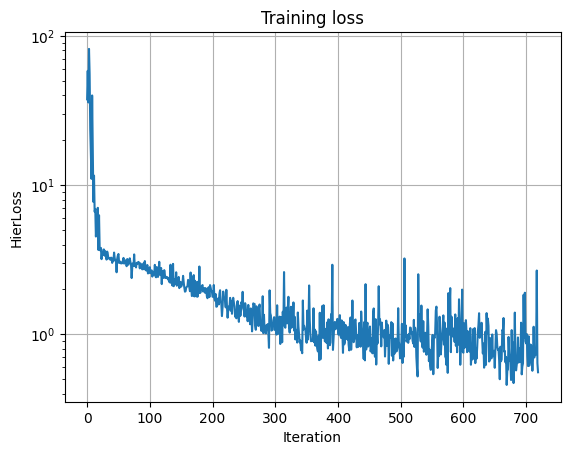

In [ ]:
# Sauvegarde de la loss + plot
Log_np = np.array(LogList, dtype=np.float32)
np.save(EXP_DIR / "train_loss.npy", Log_np)
print("Saved loss to", EXP_DIR / "train_loss.npy")

plt.figure()
plt.plot(Log_np)
plt.yscale("log")
plt.title("Training loss")
plt.xlabel("Iteration")
plt.ylabel("HierLoss")
plt.grid(True)
plt.savefig(EXP_DIR / "train_loss.png", bbox_inches="tight")
plt.show()

In [11]:
total = sum(p.numel() for p in model.parameters())
print(f"Total params: {total/1e6:.2f} M")

Total params: 6.15 M
